# Restricted Parking

- Traffic network with parking lots at certain nodes
- Agents are cars, trying to find a parking space close to their target
- (Negative) utility of each agent is the time it spends driving plus the distance it needs to walk
- We show that restricting the number of parking spaces can improve overall utility if agents know the current packing lot utilization, but not the current traffic
- If either of these two conditions do not hold, restricting parking spaces does not improve overall utility

## Definition

In [6]:
import random
from collections import Counter
import itertools
import math

import networkx as nx
import numpy as np
import pandas as pd
from scipy.special import softmax
from tqdm import trange, tqdm

In [7]:
class Car:
    def __init__(self, entry, exit, target, beta=2.0) -> None:
        self.entry = entry
        self.exit = exit
        self.target = target

        self.beta = beta # Relative disutility of walking
        self.minimum_utility = -100

        self.current_parking_lot = None
        self.current_route = None

    def utility(self, network, parking_lot):
        parking_probability = min(1.0, network.nodes[parking_lot]['capacity'] / (network.nodes[parking_lot]['utilization'] + 1))
        parking_utility = -nx.shortest_path_length(network, self.entry, parking_lot, weight='latency') - self.beta * np.linalg.norm(self.target - network.nodes[parking_lot]['position'])

        return parking_probability * parking_utility + (1 - parking_probability) * self.minimum_utility

    def route(self, network, parking_lot):
        return nx.shortest_path(network, self.entry, parking_lot, weight='latency') + nx.shortest_path(network, parking_lot, self.exit, weight='latency')[1:]
            
    def __repr__(self) -> str:
        return f'<Car {self.entry} -> {self.target} -> {self.exit}'

class ParkingModel:
    def __init__(self, network, cars) -> None:
        self.network = network
        self.cars = cars

In [8]:
def random_argmax(d):
    max_value = max(d.values())
    return np.random.choice([k for k, v in d.items() if v == max_value])

In [9]:
def run(model, number_of_steps, init=True, real_time_traffic=False, real_time_utilization=True):
    if init:
        nx.set_edge_attributes(model.network, 0, 'utilization')
        nx.set_edge_attributes(model.network, {(v, w): attr['latency_fn'](attr['utilization']) for v, w, attr in model.network.edges(data=True)}, 'latency')
        nx.set_node_attributes(model.network, 0, 'utilization')

        for car in model.cars.values():
            car.state = None

    results = []
    for step in range(number_of_steps):
        if not real_time_traffic:
            nx.set_edge_attributes(model.network, 0, 'utilization')
            nx.set_edge_attributes(model.network, {(v, w): attr['latency_fn'](attr['utilization']) for v, w, attr in model.network.edges(data=True)}, 'latency')

        if not real_time_utilization:
            nx.set_node_attributes(model.network, 0, 'utilization')

        for id in np.random.permutation(len(model.cars)):
            car = model.cars[id]

            utilities_ = {node: car.utility(model.network, node) for node in model.network.nodes}
            car.current_parking_lot = random_argmax(utilities_)
            car.current_route = car.route(model.network, car.current_parking_lot)

            if real_time_utilization:
                parking_lot_utilization = Counter(car_.current_parking_lot for car_ in model.cars.values() if car_.current_parking_lot if not None)
                nx.set_node_attributes(model.network, parking_lot_utilization, 'utilization')

            if real_time_traffic:
                road_utilization = Counter(sum((tuple(zip(car_.current_route, car_.current_route[1:])) for car_ in model.cars.values() if car_.current_route is not None), start=()))
                nx.set_edge_attributes(model.network, road_utilization, 'utilization')
                nx.set_edge_attributes(model.network, {(v, w): attr['latency_fn'](attr['utilization']) for v, w, attr in model.network.edges(data=True)}, 'latency')

        if not real_time_traffic:
            road_utilization = Counter(sum((tuple(zip(car_.current_route, car_.current_route[1:])) for car_ in model.cars.values() if car_.current_route is not None), start=()))
            nx.set_edge_attributes(model.network, road_utilization, 'utilization')
            nx.set_edge_attributes(model.network, {(v, w): attr['latency_fn'](attr['utilization']) for v, w, attr in model.network.edges(data=True)}, 'latency')

        if not real_time_utilization:
            parking_lot_utilization = Counter(car_.current_parking_lot for car_ in model.cars.values() if car_.current_parking_lot if not None)
            nx.set_node_attributes(model.network, parking_lot_utilization, 'utilization')

        results.append({'utilities': {id: car.utility(model.network, car.current_parking_lot) for id, car in model.cars.items()}, 'parking_lot_utilization': nx.get_node_attributes(model.network, 'utilization')})
    
    return pd.DataFrame(results)

## Setup

In [14]:
network = nx.DiGraph([(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)])

node_positions = {
    0: np.array([0, 1]),
    1: np.array([0.5, 1]),
    2: np.array([1, 1]),
    3: np.array([0, 0]),
    4: np.array([0.5, 0]),
    5: np.array([1, 0])
}

nx.set_node_attributes(network, node_positions, 'position')

# Latency is defined in terms of the load, i.e., the number of cars on the road
latency_fns = {
    (0, 1): lambda n: 3 + 3 * n,
    (0, 3): lambda n: 0,
    (1, 2): lambda n: 3 + 3 * n,
    (2, 5): lambda n: 0,
    (3, 4): lambda n: 3 + 3 * n,
    (4, 5): lambda n: 3 + 3 * n,
}

nx.set_edge_attributes(network, latency_fns, 'latency_fn')

nx.set_node_attributes(network, 0, 'utilization')

capacities = {
    0: 0,
    1: 10,
    2: 0,
    3: 0,
    4: 10,
    5: 0
}

nx.set_node_attributes(network, capacities, 'capacity')

nx.set_node_attributes(network, 0, 'utilization')

number_of_cars = 10
cars = {i: Car(0, 5, np.array([0.5, 0.7])) for i in range(number_of_cars)} # Parking spaces at node 1 are slightly more attractive

## Execution

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


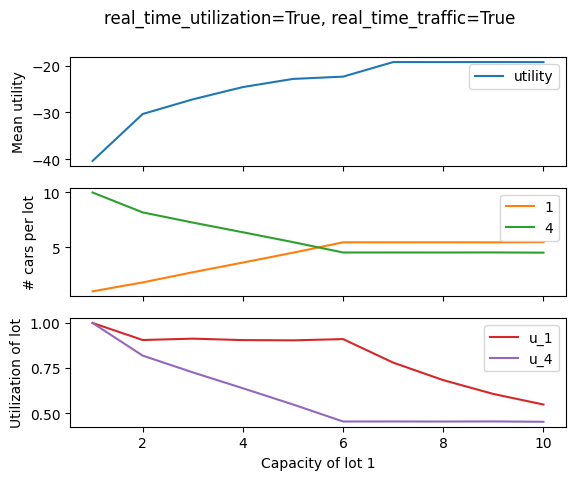

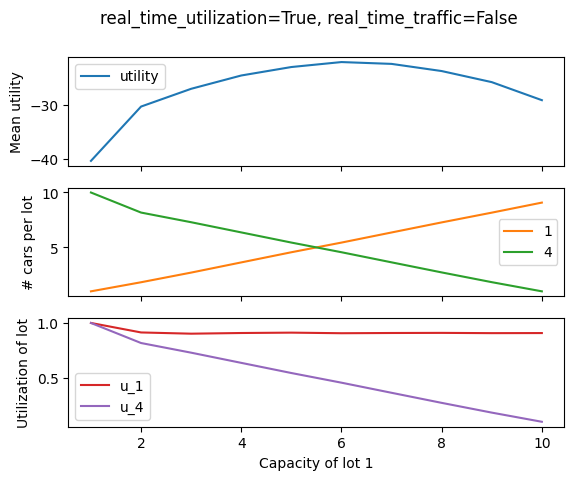

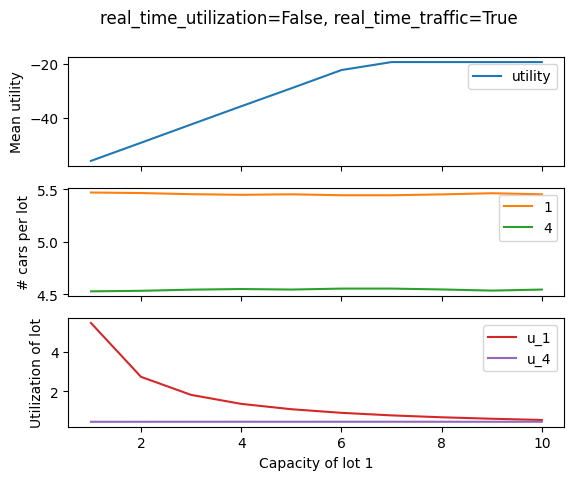

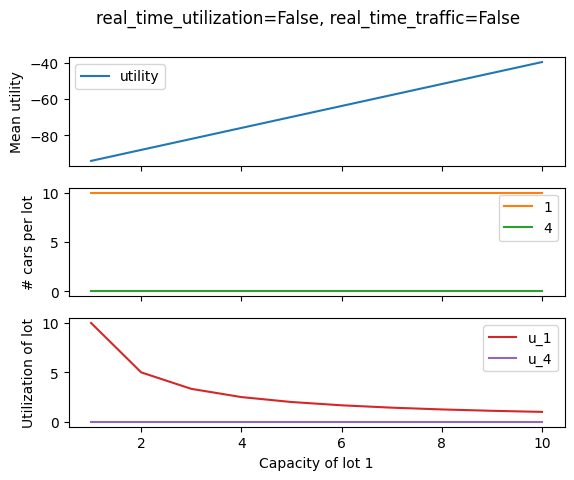

In [15]:
model = ParkingModel(network, cars)
number_of_steps = 1_000

for real_time_utilization, real_time_traffic in itertools.product([True, False], repeat=2):
    r = []
    for capacity in trange(1, 11):
        model.network.nodes[1]['capacity'] = capacity

        results = run(model, number_of_steps=number_of_steps, real_time_utilization=real_time_utilization, real_time_traffic=real_time_traffic)

        r.append({'capacity': capacity, 'utility': results['utilities'].apply(pd.Series).mean().mean(), **results['parking_lot_utilization'].apply(pd.Series)[[1, 4]].mean().to_dict()})

        for lot in [1, 4]:
            r[-1][f'u_{lot}'] = r[-1][lot] / model.network.nodes[lot]['capacity']

    r = pd.DataFrame(r).set_index('capacity')
    axes = r.plot(xlabel='Capacity of lot 1', title=f'{real_time_utilization=}, {real_time_traffic=}', subplots=[('utility', ), (1, 4), ('u_1', 'u_4')])
    axes[0].set_ylabel('Mean utility')
    axes[1].set_ylabel('# cars per lot')
    axes[2].set_ylabel('Utilization of lot')